In [2]:
import os
parent_folder = 'custom_model_training'
child_folders = ['raw_data', 'processed_data', 'models', 'logs', 'config']

if not os.path.exists( parent_folder):
    os.makedirs(parent_folder)
for folders in child_folders:
    folder_child = os.path.join(parent_folder,folders)
    if not os.path.exists(folder_child):
        os.makedirs(folder_child)
print(f'Parent folder "{parent_folder}" and child folders created successfully.')
        


Parent folder "custom_model_training" and child folders created successfully.


In [3]:
#preparing data for model 
#creating new column in label file for image name and its path
import pandas as pd
import zipfile

zipfile_path = r"C:\Users\iswar\Downloads\Dataset (1).zip"
extracted_path = r"C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project"

with zipfile.ZipFile(zipfile_path,'r')as zip_ref:
    zip_ref.extractall(extracted_path)

print("unzipped sucessfully")

unzipped sucessfully


In [4]:
data = pd.read_csv(r"C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\labels.csv" , header=None, names=["filename","class","x_min","y_min","x_max","y_max"])
file_path_image = r"C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\Images.zip"
extract_path = r"C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\image_extracted_with_fun"
with zipfile.ZipFile(file_path_image,'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("unzipped sucessfully")
padded_format = '{:08d}'
    

unzipped sucessfully


In [5]:
Image_extracted_path =  r"C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\image_extracted_with_fun\Images"
data['filepath'] = data["filename"].apply(lambda x : os.path.join(Image_extracted_path, f"{padded_format.format(x)}.jpg"))
data.to_csv(r"C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\labels.csv", index=False)
print(f"File paths have been added")

File paths have been added


In [7]:
# Preprocessing the data
missing_files = []
for fp in data['filepath']:
    if not os.path.exists(fp):
        missing_files.append(fp)  # Only append missing files to the list

# Log missing file paths to a .txt file
if missing_files:
    print(f"Missing values found for filepaths: {len(missing_files)}")
    with open("missing_files_log.txt", "w") as f:
        for file in missing_files:
            f.write(file + '\n')  # Write only missing files
    print("The missing values are stored in missing_files_log.txt")
else:
    print("All filepaths are available")


Missing values found for filepaths: 333582
The missing values are stored in missing_files_log.txt


In [8]:
valid_data = data[~data['filepath'].isin(missing_files)].copy()
valid_data.to_csv(r"C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\valid_data.csv",index=False)


In [9]:
# image preprocessing
# 1. image converter RGB
# 2. image resizing(224*224)
# 3. image normalization (0, 1)(-1,1)
# 4. Data augmentation - cropping, flipping, rotation, zooming, 
# 5. color adjustments
# 6. train_test_split
# 7. converting image to arrays
# 8. grouping or btach craetion for images to input that into model



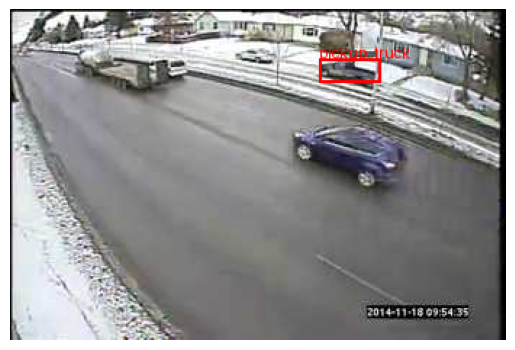

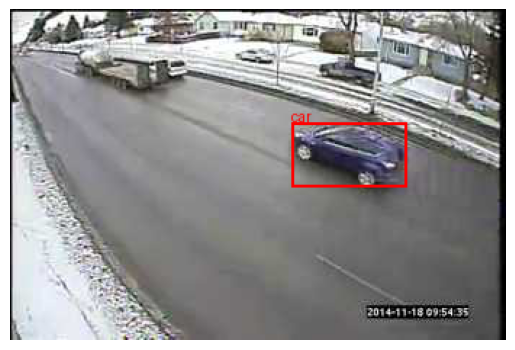

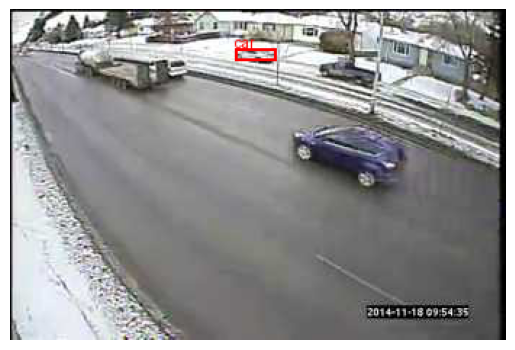

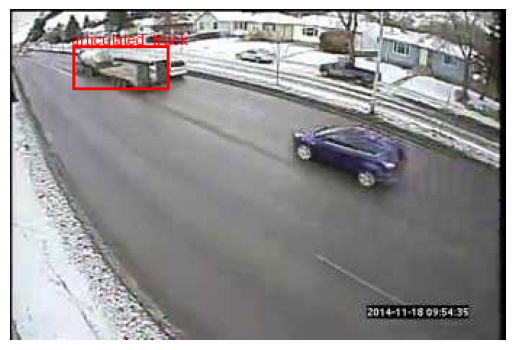

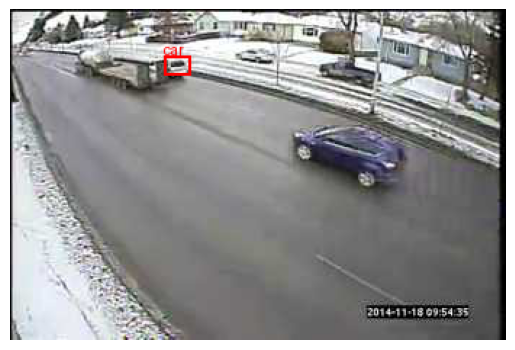

0    None
1    None
2    None
3    None
4    None
dtype: object

In [10]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
def visualization_part(row):
    img = Image.open(row['filepath']).convert('RGB')
    draw = ImageDraw.Draw(img)
    bbox = (row['x_min'], row['y_min'], row['x_max'], row['y_max']) 
    draw.rectangle(bbox, outline = "red", width=2) 
    draw.text((row['x_min'], row['y_min'] - 10), row['class'], fill="red")
    plt.imshow(img)
    plt.axis('off')
    plt.show()
valid_data.head(5).apply(visualization_part, axis = 1)

In [11]:
#creating pre processing
def get_image_size(path):
    try:
        with Image.open(path) as img:
            return img.size  # (width, height)
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return None, None  # Return placeholders for problematic images

# Apply the function and split into two columns
valid_data['image_size'] = valid_data['filepath'].apply(get_image_size)
valid_data[['image_width', 'image_height']] = pd.DataFrame(valid_data['image_size'].tolist(), index=valid_data.index)
valid_data.to_csv(r"C:\Users\iswar\custom_model_training\processed_data\output.csv", index=False)
print("Data saved to processed_data file")

Data saved to processed_data file


In [12]:
# Normalize bounding box coordinates (Vectorized)
valid_data['x_min'] = valid_data['x_min'] / valid_data['image_width']
valid_data['x_max'] = valid_data['x_max'] / valid_data['image_width']
valid_data['y_min'] = valid_data['y_min'] / valid_data['image_height']
valid_data['y_max'] = valid_data['y_max'] / valid_data['image_height']

In [13]:
#image Resizing
#function to resize the image with aspect ratio
def resize_image(image_path,target_size):
    img = Image.open(image_path)
    aspect_ratio = img.width/img.height
    if aspect_ratio > 1: #landscape iamge so we need to maintain the width properly
        new_width = min(img.width, target_size[0])
        new_height = int(new_width/aspect_ratio)
    else: 
        new_height = min(img.height, target_size[1])
        new_width = int(aspect_ratio * new_height)
    resized_image = img.resize((new_width, new_height), Image.Resampling.LANCZOS) # not sure about Lanczos need to check
    final_img = Image.new('RGB',target_size,(0,0,0))
    final_img.paste(resized_image, ((target_size[0]-new_width)//2, (target_size[1]-new_height)//2)) #padding logic need to check
    return final_img

#function to use the image filepath in df
def process_images(df, target_size):
    for i, row in df.iterrows():
        image_path = row['filepath']
        if os.path.exists(image_path):
            resized_image = resize_image(image_path, target_size)
            output_path = os.path.join("Resized_images", os.path.basename(image_path))
            resized_image.save(output_path)
    # to save it oin dataframe
            df.at[i, 'resized_filepath'] = output_path
        else:
            print('filepath not exists')
    return df

valid_data = process_images(valid_data, (640,640))
valid_data.to_csv(r"C:\Users\iswar\custom_model_training\logs\resized1.csv", index = False)

In [14]:
from sklearn.model_selection import train_test_split
#preporocessing for YOLO
#1. classes.txt file creation 2. anotations for each image 3.splitting data for Model
#1.
output_direct= r"C:\Users\iswar\custom_model_training\processed_data"
if not os.path.exists(output_direct):
    os.makedirs(output_direct)
preprocessing_path = os.path.join(output_direct,'classes.txt')
class_labels = valid_data['class'].unique()
with open (preprocessing_path, 'w') as f:
    for labels in class_labels:
        f.write(f"{labels}\n")
label_id = {label:idx for idx, label in enumerate(class_labels)}

#2 creating anotations for each image
for idx, row in valid_data.iterrows():
    image_path = row['resized_filepath']
    anotations_path = os.path.join(output_direct, os.path.splitext(os.path.basename(image_path))[0] + ".txt")
    x_centre = (row['x_min'] + row['x_max'])//2
    y_centre = (row['y_min'] + row['y_max'])//2
    width = row['x_max']-row['x_min']
    height= row['y_max']-row['y_min']
    with open(anotations_path,'w') as f:
        f.write(f"{label_id[row['class']]} { x_centre} {y_centre} {width} {height}\n")

#3 creating different files for test_data split
train_df, temp_df = train_test_split(valid_data,test_size = 0.3, random_state=42)
val_df, test_df = train_test_split(temp_df,test_size = 0.5, random_state=42)
train_df['filepath'].to_csv(os.path.join(output_direct,'train.txt'),header=False, index=False)
test_df['filepath'].to_csv(os.path.join(output_direct,'test.txt'),header=False, index=False)
val_df['filepath'].to_csv(os.path.join(output_direct,'val.txt'),header=False, index=False)

print("Preprocessing complete!")

Preprocessing complete!


In [15]:
#creating a YAML file- to direct file links for train and VAl. providing length and list of class_labels

import yaml
yaml_file_path = os.path.join(output_direct,'file.yaml')
file_yaml = {
    'train': os.path.join(output_direct,'train.txt'),
     'val': os.path.join(output_direct,'val.txt'),
     'nc': len(class_labels),
    'names': list(class_labels)
    
}
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump( file_yaml,yaml_file)

In [16]:
print(os.path.exists(r"C:\Users\iswar\yolov5s.pt"))

True


In [17]:
from ultralytics import YOLO
import os

# Set TMPDIR to a valid path
os.environ['TMPDIR'] = r'C:\Users\iswar\AppData\Local\Temp'

# Check for CUDA availability
import torch
if not torch.cuda.is_available():
    print("CUDA is not available. Using CPU.")
    device = 'cpu'
else:
    # Set the desired GPU devices
    device = '0'  # Modify if you want multiple GPUs like '0,1'

# Try to initialize YOLO model
try:
    model = YOLO(r"C:\Users\iswar\yolov5su.pt")  # Use the suggested updated model
except Exception as e:
    print(f"Error loading model: {e}")
    exit(1)  # Exit if model loading fails

# Proceed with training
try:
    # Training with updated parameters
    model.train(
        data=yaml_file_path,        # Path to your data.yaml file
        epochs=50,               # Number of epochs
        imgsz=640,               # Image size (input to the model)
        batch=8,                 # Batch size
        device=device,           # Use GPU or CPU based on availability
        lr0=0.001                # Initial learning rate
    )

    # Validate the model
    results = model.val(data=yaml_file_path)  # Path to your validation data.yaml file
    print(results)

except Exception as e:
    print(f"Error during training or validation: {e}")

CUDA is not available. Using CPU.
Ultralytics 8.3.53  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 5 7520U with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=C:\Users\iswar\yolov5su.pt, data=C:\Users\iswar\custom_model_training\processed_data\file.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

train: Scanning C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\image_extracte

train: WARNING  No labels found in C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\image_extracted_with_fun\Images.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


train: New cache created: C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\image_extracted_with_fun\Images.cache
WARNING  No labels found in C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\image_extracted_with_fun\Images.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


val: Scanning C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\image_extracted_

val: WARNING  No labels found in C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\image_extracted_with_fun\Images.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


val: New cache created: C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\image_extracted_with_fun\Images.cache
WARNING  No labels found in C:\Users\iswar\OneDrive\Desktop\iswarya\letstry\capstone\tesla_project\Capstone 1\Part 1\image_extracted_with_fun\Images.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
Plotting labels to runs\detect\train3\labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 50 epochs...

   

       1/50         0G          0      18.47          0          0        640: 100%|██████████| 1572/1572 [27:43:08<00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [11:

Error during training or validation: torch.cat(): expected a non-empty list of Tensors
